In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from datetime import datetime

from QLSTM import SequenceDataset

import yfinance as yf

import scienceplots

# plt.style.use(['science','ieee'])
plt.rcParams['axes.grid'] = True
# no use latex
plt.rcParams['text.usetex'] = False

In [3]:
columns = ["Close"]

#df = pd.read_csv('./AAPL_2022-01-01_2023-01-01.csv')
#data = df.filter(columns)

df = yf.download("AAPL", start="2022-01-01", end="2025-01-01", auto_adjust=False)
data = df.iloc[:, 1] # [ ?, close, high, low, open, volume]

dataset = data.values

[*********************100%***********************]  1 of 1 completed


In [4]:
# Splitting the data into train and test
size = int(len(df) * 0.7)
df_train = dataset[:size].copy()
df_test = dataset[size:].copy()

In [5]:
# Select the features
df_train = pd.DataFrame(df_train, columns=columns)
df_test = pd.DataFrame(df_test, columns=columns)

features = df_train.columns
target = 'Close'

In [6]:
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

In [7]:
# Normalizing the data
df_train, min_train, max_train = normalize(df_train)
df_test, _, _ = normalize(df_test, min_train, max_train)

def denorm(a):
    return a * (max_train - min_train + 0.0001) + min_train

In [8]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 1])
Target shape: torch.Size([1])


In [9]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function): 
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    # Just like `test_loop` function but keep track of the outputs instead of the loss function
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

def predict_autoregressive(data_loader, model, sequence_length):
    outputs = []

    # First, gather all X from the data_loader
    all_X = []
    for X_batch, _ in data_loader:
        all_X.append(X_batch)
    
    all_X = torch.cat(all_X, dim=0)  # (num_samples, sequence_length, num_features)

    # Start with the first sequence
    current_input = all_X[0].unsqueeze(0)  # (1, sequence_length, num_features)

    model.eval()
    with torch.no_grad():
        for t in range(all_X.shape[0]):
            y_star = model(current_input)
            outputs.append(y_star.item())

            # Now update current_input for next prediction
            if t + 1 < all_X.shape[0]:
                next_input = current_input.squeeze(0)[1:, :]  # drop oldest time step
                next_features = all_X[t + 1, -1, :].clone()   # next true features
                next_features[0] = y_star                     # replace target with prediction
                next_input = torch.cat((next_input, next_features.unsqueeze(0)), dim=0)
                current_input = next_input.unsqueeze(0)

    return torch.tensor(outputs)

In [10]:
from QLSTM import ShallowRegressionLSTM

learning_rate = 0.01
num_hidden_units = 7

model = ShallowRegressionLSTM(
    num_sensors=len(features),
    hidden_units=num_hidden_units,
    num_layers=1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Count number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 288


In [12]:
classical_loss_train = []
classical_loss_test = []
print("Untrained test\n--------")
# test_loss = test_model(test_loader, model, loss_function)
print()

num_epochs = 50

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)

Untrained test
--------

Epoch 0
---------
Train loss: 0.006755391650108395
Test loss: 0.03327257347562795
Epoch 1
---------
Train loss: 0.0010384383973048614
Test loss: 0.009184764249386839
Epoch 2
---------
Train loss: 0.00015731763912563113
Test loss: 0.003483934259804095
Epoch 3
---------
Train loss: 1.6663326984959074e-05
Test loss: 0.0010185096774376987
Epoch 4
---------
Train loss: 3.8282796835665726e-05
Test loss: 0.0020024381706701586
Epoch 5
---------
Train loss: 2.4214695034437077e-05
Test loss: 0.002777291135445551
Epoch 6
---------
Train loss: 8.305894977001814e-05
Test loss: 0.0019776153368205925
Epoch 7
---------
Train loss: 7.314540328541019e-05
Test loss: 0.0019623903732538736
Epoch 8
---------
Train loss: 0.00027755125764710267
Test loss: 0.00370669587964766
Epoch 9
---------
Train loss: 3.4064288147022794e-05
Test loss: 0.002324895096749639
Epoch 10
---------
Train loss: 9.572177805493907e-05
Test loss: 0.00603106067259899
Epoch 11
---------
Train loss: 0.00012231158

In [13]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model Forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, model).numpy()
df_test[ystar_col_Q] = predict(test_eval_loader, model).numpy()

# auto regressive predictions
#df_train[ystar_col_Q] = predict_autoregressive(train_eval_loader, model, sequence_length).numpy()
#df_test[ystar_col_Q] = predict_autoregressive(test_eval_loader, model, sequence_length).numpy()

In [14]:
# de normalize the data

df_train_raw = df_train.map(lambda x: denorm(x))
df_test_raw = df_test.map(lambda x: denorm(x))

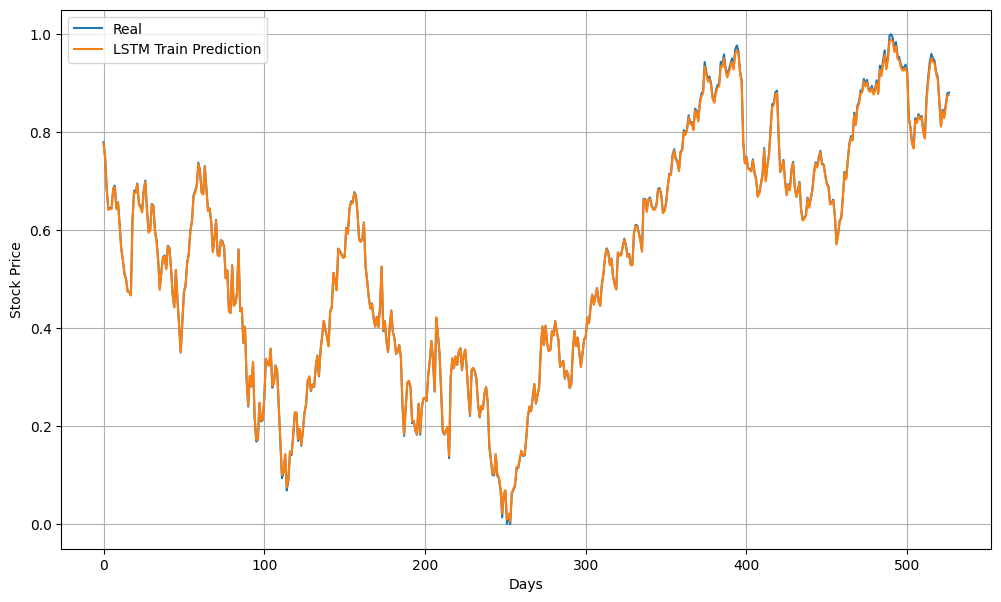

In [15]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_train)), df_train[columns], label = "Real")
plt.plot(range(len(df_train)), df_train["Model Forecast"], label = "LSTM Train Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend()
plt.show()

/opt/anaconda3/envs/general/lib/python3.10/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/opt/anaconda3/envs/general/lib/python3.10/site-packages/matplotlib/cbook.py:1355: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


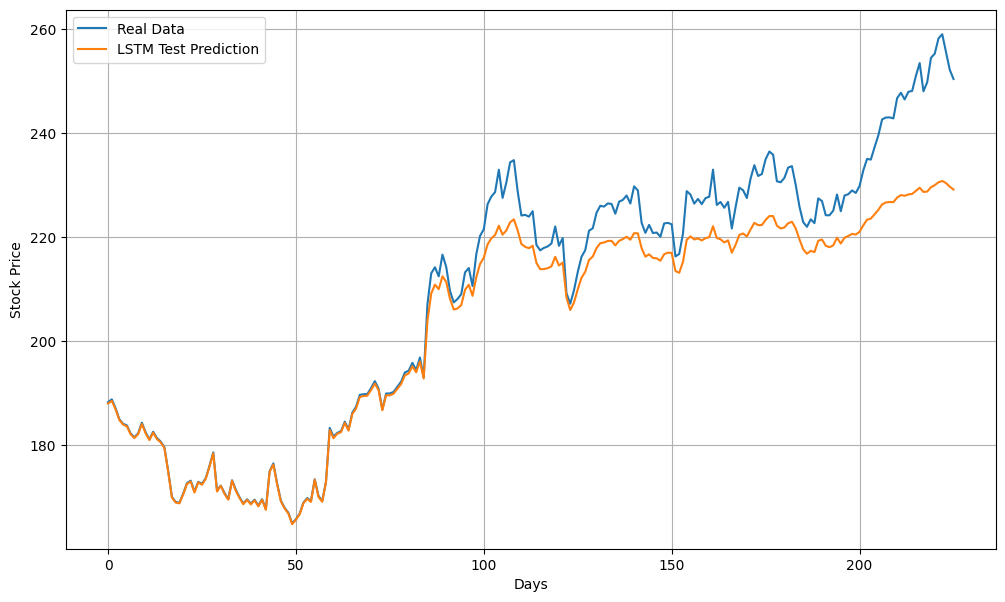

In [16]:
cutoff = 0 # 0-74

plt.figure(figsize=(12, 7))
plt.plot(range(cutoff, len(df_test)), df_test_raw["Close"][cutoff:], label = "Real Data", marker='')
plt.plot(range(cutoff, len(df_test)), df_test_raw["Model Forecast"][cutoff:], label = "LSTM Test Prediction", marker='')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend()
plt.show()

In [17]:
# df_test.to_csv('AAPL_2022-01-01_2023-01-01_LSTM.csv', index=False)

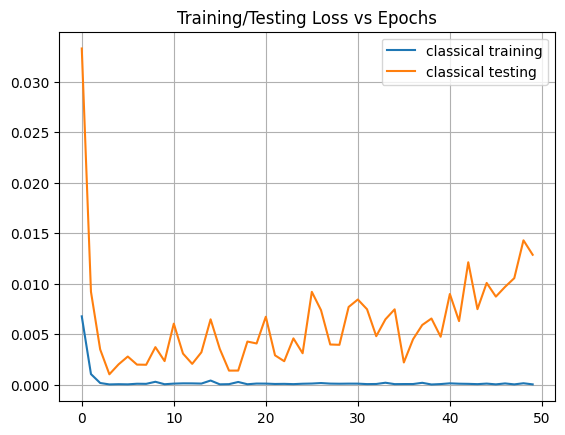

In [18]:
plt.plot(classical_loss_train, label='classical training')
plt.plot(classical_loss_test, label='classical testing')
pd.DataFrame(classical_loss_train).to_csv('LSTM_loss.csv', index=False)
plt.title('Training/Testing Loss vs Epochs')
plt.legend()

In [19]:
# Log loss graph

#plt.plot(np.log10(classical_loss_train), label='classical training')
#plt.plot(np.log10(classical_loss_test), label='classical testing')
#pd.DataFrame(classical_loss_train).to_csv('LSTM_loss.csv', index=False)
#plt.title('Semi-Log Training/Testing Loss vs Epochs')
#plt.legend()

In [20]:
def round_sigfig(x, sf):
    if x == 0:
        return 0
    magnitude = np.floor(np.log10(abs(x)))
    factor = 10 ** (sf - 1 - magnitude)
    return round(x * factor) / factor

In [21]:
# Calculate the RMSE for the train and test data
from sklearn.metrics import mean_squared_error

train_rmse = math.sqrt(mean_squared_error(df_train[columns], df_train["Model Forecast"]))
test_rmse = math.sqrt(mean_squared_error(df_test[columns], df_test["Model Forecast"]))
print(f"Train RMSE: {1000 * round_sigfig(train_rmse, 3)} * 10^3")
print(f"Test RMSE:  {1000 * round_sigfig(test_rmse, 3)} * 10^3")

Train RMSE: 2.92 * 10^3
Test RMSE:  113.0 * 10^3


In [22]:
# Calculate the accuracy of the model
def accuracy(y, y_star):
    return np.mean(np.abs(y - y_star) < 0.01)

def avg_dif(y, y_star):
    return np.mean(np.abs(y - y_star))

train_accuracy = accuracy(df_train["Close"], df_train["Model Forecast"])
test_accuracy = accuracy(df_test["Close"], df_test["Model Forecast"])
print(f"Train accuracy: {round_sigfig(train_accuracy, 3)}")
print(f"Test accuracy:  {round_sigfig(test_accuracy, 3)}")


train_raw_avg_dif = avg_dif(df_train_raw["Close"], df_train_raw["Model Forecast"])
test_raw_avg_dif = avg_dif(df_test_raw["Close"], df_test_raw["Model Forecast"])
print(f"Train raw average difference: {round_sigfig(train_raw_avg_dif, 4)} $")
print(f"Test raw average difference: {round_sigfig(test_raw_avg_dif, 4)} $")

Train accuracy: 0.996
Test accuracy:  0.372
Train raw average difference: 0.1556 $
Test raw average difference: 5.518 $


/opt/anaconda3/envs/general/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
